In [1]:
import numpy as np
import pandas as pd
import kagglehub

from abc import ABC

from sklearn.metrics import mean_absolute_percentage_error as mape

from statsforecast.models import AutoTheta, AutoARIMA, AutoETS
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Data Processing

1. Download information from Kaggle

In [197]:
path = kagglehub.dataset_download(
    "rickandjoe/electricity-transformer-dataset-etdataset"
)

ConnectTimeout: HTTPSConnectionPool(host='www.kaggle.com', port=443): Max retries exceeded with url: /api/v1/datasets/view/rickandjoe/electricity-transformer-dataset-etdataset (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x34a15e910>, 'Connection to www.kaggle.com timed out. (connect timeout=5)'))

2. Load the dataframes

In [198]:
df1 = pd.read_csv(path + "/ETT-small/ETTh1.csv", index_col=0)

In [199]:
df1["unique_id"] = "transformer_1"

In [200]:
df2 = pd.read_csv(path + "/ETT-small/ETTh2.csv", index_col=0)

In [201]:
df2["unique_id"] = "transformer_2"

Concatenate both dataframes

In [202]:
df_final = pd.concat([df1, df2])

3. Drop useless information

In [203]:
df_final = df_final[["unique_id", "OT"]]

4. Rename the DF to get the final prediction

In [204]:
df_final = df_final.reset_index()

5. Rename the columns to have a common format

In [205]:
df_final = df_final.rename(columns={"date": "ds", "OT": "y"})

In [206]:
df_final["ds"] = pd.to_datetime(df_final["ds"])

In [207]:
df_final = df_final.sort_values(["unique_id", "ds"])

## Date-Split

Define a variable for the split

In [208]:
SPLIT_DATE = "2018-06-22 20:00:00"

Get the train and test

In [209]:
train = df_final[df_final["ds"] < SPLIT_DATE]
test = df_final[df_final["ds"] >= SPLIT_DATE]

## Modeling

### Model Definition

Create an abstract class the handles all the model functionalities

In [210]:
class ForecastingBaseModel(ABC):
    def __init__(self, freq: str, n_jobs: int = 1) -> None:
        self.model = None
        self.freq = freq
        self.n_jobs = n_jobs

    def fit(
        self, df: pd.DataFrame, date_col: str, item_col: str, targe_col: str
    ) -> None:
        pass

    def predict(self, n_steps: int) -> pd.DataFrame:
        pass

    def evaluate_model(self, y_true: np.array, y_pred: np.array) -> None:
        print("MAPE: ", mape(y_true=y_true, y_pred=y_pred))

Create a model class for the StatsModels

In [211]:
class StatsForecaster(ForecastingBaseModel):
    def __init__(self, freq: str = "H", n_jobs: int = -1) -> None:
        super().__init__(freq=freq, n_jobs=n_jobs)

    def fit(
        self, df: pd.DataFrame, date_col: str, item_col: str, target_col: str
    ) -> None:
        self.df = df.copy()
        self.date_col = date_col
        self.model = StatsForecast(
            models=[AutoARIMA(), AutoETS(), AutoTheta()],
            freq=self.freq,
            n_jobs=self.n_jobs,
        )
        self.model.fit(
            df=self.df, time_col=date_col, target_col=target_col, id_col=item_col
        )

    def predict(self, n_steps: int) -> pd.DataFrame:
        results = self.model.predict(h=n_steps)
        results = results.rename(columns={self.date_col: "ds"})
        return results

Create a class for the AWS Chronos model

In [212]:
class ChronosForecaster(ForecastingBaseModel):
    def __init__(self, freq: str = "H"):
        super().__init__(freq=freq)

    def fit(
        self, df: pd.DataFrame, date_col: str, item_col: str, target_col: str
    ) -> None:
        self.item_id = item_col
        df = df.copy()
        df = df.rename(columns={target_col: "target"})
        self.df = TimeSeriesDataFrame.from_data_frame(
            df,
            id_column=item_col,
            timestamp_column=date_col,
        )

    def predict(self, n_steps):
        self.model = TimeSeriesPredictor(
            prediction_length=n_steps, freq=self.freq, verbosity=0
        ).fit(self.df, presets="bolt_base")
        results = self.model.predict(self.df)
        results = results.to_data_frame().reset_index()
        results = results[["mean", "item_id", "timestamp"]]
        results = results.rename(
            columns={
                "mean": "AWSChronosForecast",
                "item_id": "unique_id",
                "timestamp": "ds",
            }
        )
        return results

### Model training

Try the models

In [213]:
chronos_model = ChronosForecaster(freq="h")

In [214]:
chronos_model.fit(df=train, date_col="ds", item_col="unique_id", target_col="y")

In [215]:
stats_model = StatsForecaster(freq="h", n_jobs=-1)

In [216]:
stats_model.fit(df=train, date_col="ds", item_col="unique_id", target_col="y")

### Model evaluation

Define the horizon lenght

In [217]:
HORIZON_LEN = 96

In [218]:
y_pred_chronos = chronos_model.predict(n_steps=HORIZON_LEN)

In [219]:
y_pred_stats = stats_model.predict(n_steps=HORIZON_LEN)

Join the results

In [220]:
y_pred_final = pd.merge(
    y_pred_chronos, y_pred_stats, on=["unique_id", "ds"], how="inner"
)

Plot the results

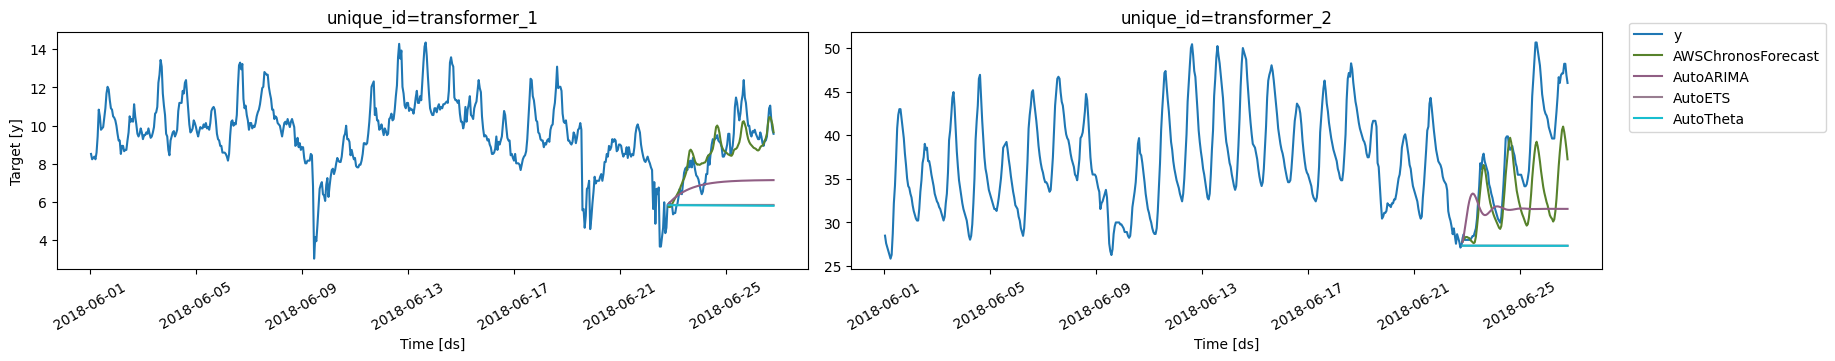

In [221]:
plot_series(df_final.query('ds > "2018-06-01"'), y_pred_final)

## Metrics evaluation

Create a function that can perform those calculations

In [222]:
class ForecastEvaluation:
    def __init__(self):
        pass

    def evaluate(
        self, df: pd.DataFrame, predicted_cols: list, y_true: np.array
    ) -> None:
        mape_results = {
            col: mape(y_true=y_true, y_pred=df[col].values) * 100
            for col in predicted_cols
        }
        return pd.DataFrame([mape_results])

In [223]:
forecast_evaluator = ForecastEvaluation()

In [224]:
mape_results = forecast_evaluator.evaluate(
    df=y_pred_final,
    predicted_cols=["AWSChronosForecast", "AutoARIMA", "AutoETS", "AutoTheta"],
    y_true=test["y"].values,
)

In [225]:
mape_results

,AWSChronosForecast,AutoARIMA,AutoETS,AutoTheta
0,9.148477,18.487053,27.713882,27.880458
